In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv
import shutil
from tqdm import tqdm
os.getcwd()
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.2.0


In [2]:
#Ref: https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
import keras 
from keras.layers import *
from keras.models import *

traindf=pd.read_csv('train.csv',dtype=str)
testdf=pd.read_csv('test.csv',dtype=str)

traindf['age']=traindf.age.astype('int64')
#traindf['gender']=traindf.gender.astype('int64')

testdf['age']=traindf.age.astype('int64')
#testdf['gender']=traindf.gender.astype('int64')


print(traindf.head())
print(testdf.head())

print(traindf.info())
print(testdf.info())


Using TensorFlow backend.


                                           full_path gender  age
0  data/imdb/50/nm0004950_rm4036071168_1972-4-17_...      0   38
1  data/imdb/77/nm0004977_rm474265344_1973-7-15_2...      1   37
2  data/imdb/21/nm0019221_rm3640760320_1948-9-11_...      1   16
3  data/imdb/34/nm1289434_rm2872508160_1983-2-23_...      0   32
4  data/imdb/90/nm0001590_rm687003392_1952-5-15_2...      1   57
                                           full_path gender  age
0  data/imdb/44/nm0089244_rm238668800_1939-8-7_19...      0   38
1          data/wiki/21/32518421_1991-09-01_2015.jpg      1   37
2          data/wiki/76/38687576_1939-08-29_1961.jpg      1   16
3  data/imdb/88/nm0005388_rm594123264_1970-5-15_2...      1   32
4  data/imdb/25/nm0001325_rm2254805248_1959-11-3_...      1   57
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156918 entries, 0 to 156917
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   full_path  156918 non-nul

In [5]:
#train and validation data generators

img_dim=128

#Include data augmentation:
datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.2)

train_generator=datagen.flow_from_dataframe(dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age','gender'],
subset="training",
#try a smaller batch size                                            
batch_size=32,
seed=42,
shuffle=True,
class_mode='multi_output', 
target_size=(img_dim,img_dim))


valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory=None,
x_col='full_path',
y_col=['age','gender'],
subset="validation",
batch_size=32, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=True,
class_mode='multi_output',
target_size=(img_dim,img_dim))

#cannot have a separate valid datagen as no input

Found 125535 validated image filenames.
Found 31383 validated image filenames.


In [6]:
#test data generator

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory=None,
x_col='full_path',
y_col=None,
batch_size=1, #***Set this to some number that divides your total number of images in your test set exactly
seed=42,
shuffle=False,
class_mode=None,
target_size=(img_dim,img_dim))

Found 52566 validated image filenames.


In [70]:
#Define model

inputs = Input(shape = (img_dim,img_dim, 3))

# Begin
model = Conv2D(filters=32, kernel_size=(3, 3), padding='same', strides= 2, activation='relu', input_shape=(img_dim, img_dim, 3))(inputs)
model = MaxPool2D(pool_size=(3, 3), strides= 2)(model)
model = BatchNormalization(momentum=0.15)(model)

model = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model)
model = BatchNormalization(momentum=0.15)(model)
model = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(model)
model=Flatten()(model)

age_model = Dense(128, activation='relu')(model)
age_model= Dropout(0.4)(age_model)
age_model = Dense(256, activation='relu')(age_model)
age_model= Dropout(0.4)(age_model)
age_model = Dense(1, activation='linear',name='age')(age_model)

gender_model = Dense(128, activation='relu')(model)
gender_model = Dropout(0.4)(gender_model)
gender_model = Dense(256, activation='relu')(gender_model)
gender_model = Dropout(0.4)(gender_model)
gender_model = Dense(1, activation='sigmoid',name='gender')(gender_model)

In [71]:
model = Model(inputs=inputs, outputs=[age_model,gender_model])
#change to default lr
model.compile(optimizer = tf.keras.optimizers.Adam(0.002), 
              loss ={'age':'mse','gender':'binary_crossentropy'},metrics={'age':'mae',"gender":"accuracy"})
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 64, 64, 32)   896         input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 31, 31, 32)   0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_17 (BatchNo (None, 31, 31, 32)   128         max_pooling2d_9[0][0]            
____________________________________________________________________________________________

In [72]:
#https://medium.com/@vijayabhaskar96/multi-label-image-classification-tutorial-with-keras-imagedatagenerator-cd541f8eaf24
#https://gist.github.com/rragundez/8b1b9e190abef8ffb6d93f03f8e0e091

#def generator_wrapper(generator):
#    for batch_x,batch_y in generator:
#        yield (batch_x,[batch_y[:i] for i in range(2)]) #for the two outputs required: gender and age


In [73]:
callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss',restore_best_weights=True)]

#steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
#validation_steps = TotalvalidationSamples / ValidationBatchSize

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

#for one output:
history = model.fit_generator(generator=train_generator,steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                    epochs=20,callbacks=callbacks)

#history = model.fit_generator(generator=generator_wrapper(train_generator),steps_per_epoch=STEP_SIZE_TRAIN,
#                    validation_data=generator_wrapper(valid_generator),
#                    validation_steps=STEP_SIZE_VALID,
#                    epochs=5,verbose=2)


Epoch 1/20
 454/3922 [==>...........................] - ETA: 39:14 - loss: 374.7128 - age_loss: 373.5835 - gender_loss: 1.1294 - age_mae: 14.4145 - gender_accuracy: 0.4996

KeyboardInterrupt: 

In [11]:
model.save("cnn_multitask.h5")
print("Saved model to disk")

Saved model to disk


/Users/varuni/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


In [12]:
print(history.history.keys())

dict_keys(['val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_mae', 'val_gender_accuracy', 'loss', 'age_loss', 'gender_loss', 'age_mae', 'gender_accuracy'])


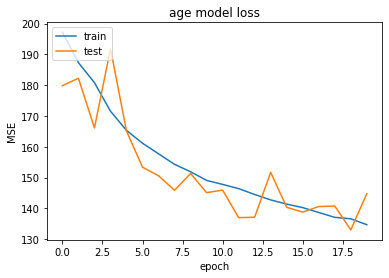

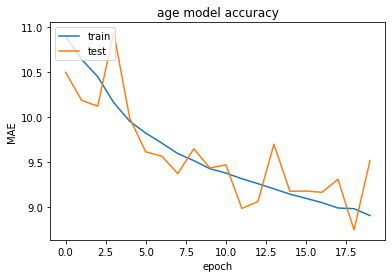

<Figure size 432x288 with 0 Axes>

In [13]:
#Plot age history
plt.plot(history.history['age_loss'])
plt.plot(history.history['val_age_loss'])
plt.title('age model loss')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_mse.png')
plt.clf()

plt.plot(history.history['age_mae'])
plt.plot(history.history['val_age_mae'])
plt.title('age model accuracy')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('age_mae.png')
plt.clf()

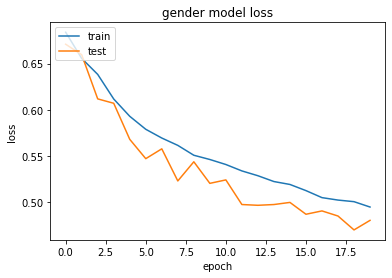

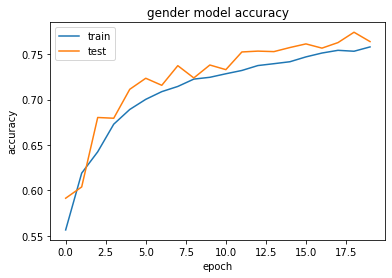

<Figure size 432x288 with 0 Axes>

In [14]:
#Plot gender history

plt.plot(history.history['gender_loss'])
plt.plot(history.history['val_gender_loss'])
plt.title('gender model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('gender_loss.png')
plt.clf()

plt.plot(history.history['gender_accuracy'])
plt.plot(history.history['val_gender_accuracy'])
plt.title('gender model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('gender_accuracy.png')
plt.clf()


In [15]:
#Evaluate
#model.evaluate_generator(generator=valid_generator,steps=STEP_SIZE_TEST)

In [16]:

#Predict
test_generator.reset() #reset the test_generator before whenever you call the predict_generator
#pred_age,pred_gender=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)
predictions=model.predict_generator(test_generator,steps=STEP_SIZE_TEST,verbose=1)

#filenames=test_generator.filenames
#results=pd.DataFrame({"Filename":filenames,"Age Predictions":pred_age, "Gender Predictions":pred_gender})
#results.to_csv("cnn_results.csv",index=False)


 2430/52566 [>.............................] - ETA: 4:36

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 3. 
  warnings.warn(str(msg))


11250/52566 [=====>........................] - ETA: 3:44

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:786: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16036032132 bytes but only got 0. Skipping tag 50687
  " Skipping tag %s" % (size, len(data), tag)


34122/52566 [==================>...........] - ETA: 1:44

/Users/varuni/anaconda3/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:804: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


52566/52566 [==============================] - 294s 6ms/step


In [45]:
print(predictions[0])

[[35.9906  ]
 [42.350792]
 [37.450207]
 ...
 [35.81482 ]
 [36.076553]
 [40.498722]]


In [32]:
gender_results=[]
for item in predictions[1]:
    if item<=0.5:
        gender_results.append('0')
    else:
        gender_results.append('1')
        

In [44]:
results=pd.DataFrame({'Age':predictions[0].flatten().astype(int),'Gender':gender_results})
print(results.head())

results.to_csv("cnn_results.csv",index=False)

   Age Gender
0   35      1
1   42      1
2   37      1
3   45      1
4   42      1


In [46]:
results.Gender.value_counts()

1    40155
0    12411
Name: Gender, dtype: int64